 Cài đặt thư viện cần thiết

In [1]:
!pip install -q transformers underthesea pyvi scikit-learn pandas tqdm openpyxl torch torchvision seaborn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00


 Import các thư viện

In [2]:
import torch
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from underthesea import word_tokenize
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style='whitegrid')

## 3️ Đọc dữ liệu và tiền xử lý
 `/content/file đã xử lí hoàn tất.xlsx`

In [3]:
file_path = '/content/file đã xử lí hoàn tất.xlsx'
df = pd.read_excel(file_path)
print('Số dòng dữ liệu:', len(df))
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-ZÀ-Ỹà-ỹ0-9\s]", " ", text)
    text = word_tokenize(text, format='text')
    return text.strip()

tqdm.pandas()
if 'Lyric_clean' not in df.columns:
    df['Lyric_clean'] = df['Lyric'].progress_apply(preprocess_text)
df[['Lyric','Lyric_clean']].head()

Số dòng dữ liệu: 587


100%|██████████| 587/587 [00:06<00:00, 90.49it/s] 


,Lyric,Lyric_clean
0,"Là người — làm tất cả để cho con nở nụ cười, l...",là người làm tất_cả để cho con nở nụ cười là m...
1,"Cuộc đời đầy ắp những khúc mắc chia ly, nụ cườ...",cuộc_đời đầy_ắp những khúc mắc chia_ly nụ cười...
2,Mở cửa sổ mở tâm hồn cảm giác một khung tranh...,mở cửa_sổ mở tâm_hồn cảm_giác một khung tranh_...
3,Mở cửa sổ mở tâm hồn cảm giác một khung tranh...,mở cửa_sổ mở tâm_hồn cảm_giác một khung tranh_...
4,: Đi sao cho nó gắt chơi sao cho nó gắt bo cua...,đi sao cho nó gắt_chơi sao cho nó gắt bo_cua c...


## 4️ Sinh embedding bằng PhoBERT


In [4]:
model_name = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name)

def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embedding.numpy()

sentences = df['Lyric_clean'].tolist()
embeddings = np.vstack([get_sentence_embedding(s) for s in tqdm(sentences)])
print('Embeddings shape:', embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]


100%|██████████| 587/587 [05:53<00:00,  1.66it/s]

Embeddings shape: (587, 768)


## 5️ Chạy 4 mô hình phân cụm
 KMeans (n_clusters=12)
 AgglomerativeClustering (n_clusters=12)
 DBSCAN (eps=0.5, min_samples=5) —
 GaussianMixture (n_components=12)



In [5]:
n_clusters = 12
results = {}

# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(embeddings)
results['KMeans'] = labels_km
df['Cluster_KMeans'] = labels_km

# Agglomerative
agg = AgglomerativeClustering(n_clusters=n_clusters)
labels_agg = agg.fit_predict(embeddings)
results['Agglomerative'] = labels_agg
df['Cluster_Agg'] = labels_agg

# DBSCAN (thử giá trị mặc định, bạn có thể tinh chỉnh eps/min_samples)
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(embeddings)
results['DBSCAN'] = labels_db
df['Cluster_DBSCAN'] = labels_db

# Gaussian Mixture
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(embeddings)
results['GMM'] = labels_gmm
df['Cluster_GMM'] = labels_gmm

print('Finished clustering. Example counts:')
for name, lab in results.items():
    unique, counts = np.unique(lab, return_counts=True)
    print(f"{name}: {dict(zip(unique.tolist(), counts.tolist()))}")

Finished clustering. Example counts:
KMeans: {0: 71, 1: 65, 2: 89, 3: 43, 4: 20, 5: 66, 6: 74, 7: 14, 8: 58, 9: 75, 10: 1, 11: 11}
Agglomerative: {0: 44, 1: 38, 2: 96, 3: 45, 4: 60, 5: 49, 6: 71, 7: 14, 8: 61, 9: 45, 10: 3, 11: 61}
DBSCAN: {-1: 587}
GMM: {0: 30, 1: 89, 2: 89, 3: 58, 4: 14, 5: 52, 6: 87, 7: 75, 8: 15, 9: 41, 10: 33, 11: 4}


 Tính chỉ số đánh giá phân cụm
Sử dụng Silhouette (nên >= -1 và <=1), Calinski-Harabasz (càng cao càng tốt), Davies-Bouldin (càng thấp càng tốt).
Lưu ý: một số chỉ số yêu cầu ≥2 cluster; DBSCAN có thể tạo ra nhiễu (-1).

In [6]:
metrics = {}
for name, labels in results.items():
    try:
        n_unique = len(set(labels)) - (1 if -1 in labels else 0)
        if n_unique <= 1:
            raise ValueError('Not enough clusters for metrics')
        sil = silhouette_score(embeddings, labels)
        ch = calinski_harabasz_score(embeddings, labels)
        dbi = davies_bouldin_score(embeddings, labels)
    except Exception as e:
        sil, ch, dbi = None, None, None
    metrics[name] = {'silhouette': sil, 'calinski_harabasz': ch, 'davies_bouldin': dbi}

import pprint
pprint.pprint(metrics)

{'Agglomerative': {'calinski_harabasz': np.float32(28.91966),
                   'davies_bouldin': np.float64(2.901877725563365),
                   'silhouette': np.float32(0.05422978)},
 'DBSCAN': {'calinski_harabasz': None,
            'davies_bouldin': None,
            'silhouette': None},
 'GMM': {'calinski_harabasz': np.float32(29.665878),
         'davies_bouldin': np.float64(2.7871031046599968),
         'silhouette': np.float32(0.07046001)},
 'KMeans': {'calinski_harabasz': np.float32(31.019285),
            'davies_bouldin': np.float64(2.4699097897449946),
            'silhouette': np.float32(0.078172386)}}


## 7️ Giảm chiều với t-SNE và trực quan hóa từng mô hình
t-SNE sẽ chạy trên `embeddings` để tạo `tsne_2d`.
Sau đó vẽ scatter plot cho từng mô hình, màu theo nhãn cụm.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done: (587, 2)


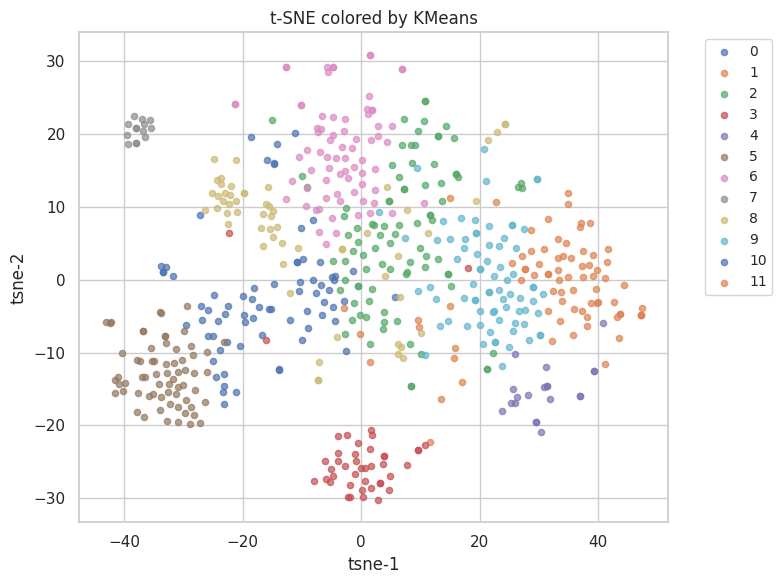

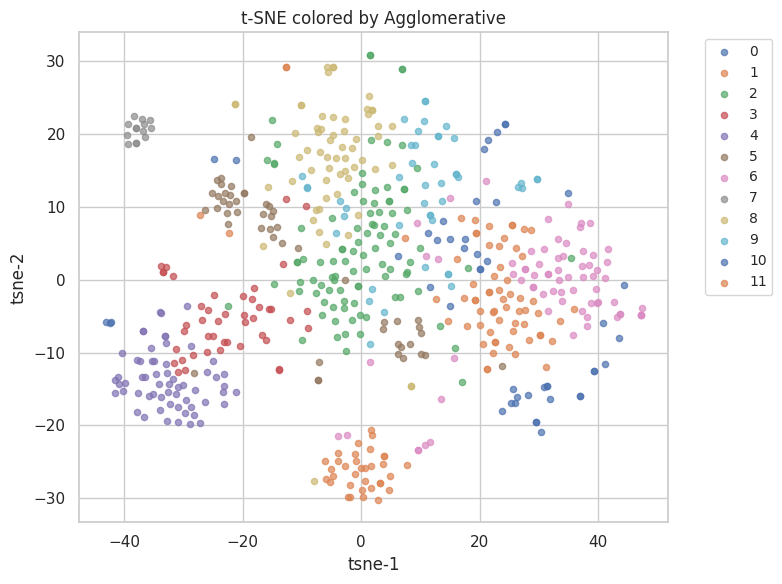

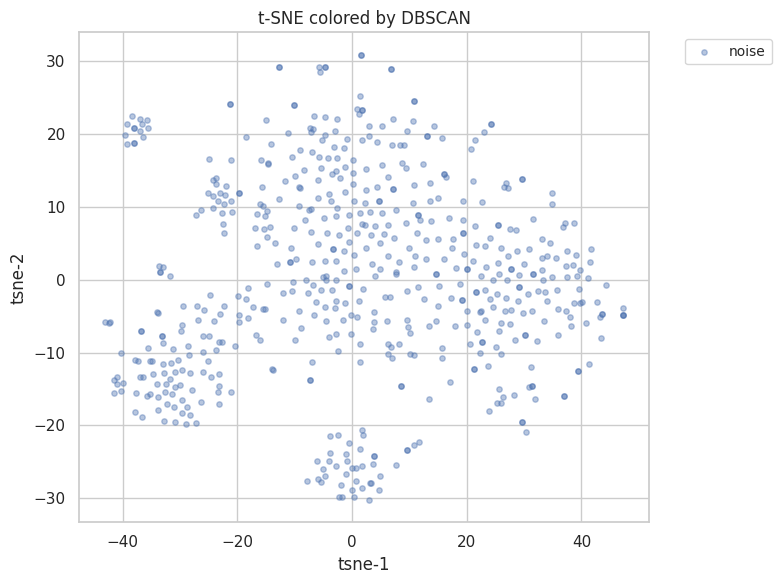

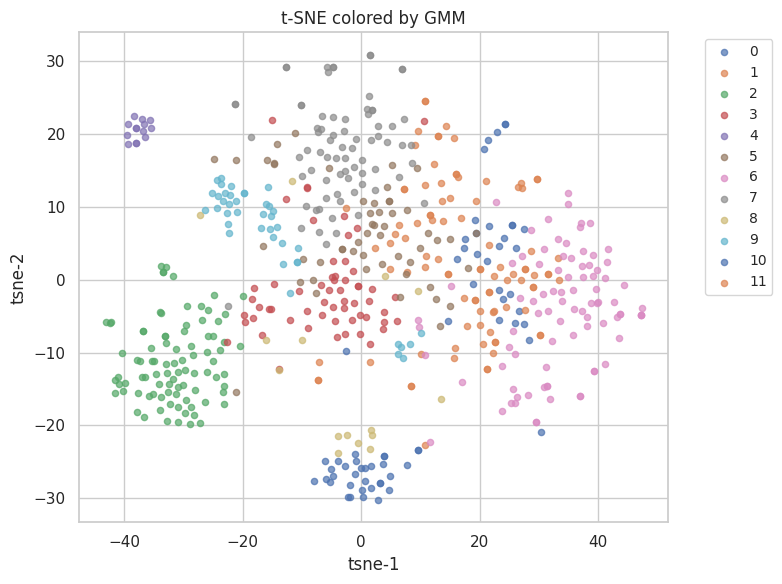

In [7]:
# Chạy t-SNE (chậm nếu dữ liệu lớn)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_2d = tsne.fit_transform(embeddings)
print('t-SNE done:', tsne_2d.shape)

def plot_tsne_by_labels(tsne_2d, labels, title='t-SNE'):
    plt.figure(figsize=(8,6))
    unique = np.unique(labels)
    for u in unique:
        mask = labels == u
        if u == -1:
            plt.scatter(tsne_2d[mask,0], tsne_2d[mask,1], s=15, alpha=0.4, label='noise')
        else:
            plt.scatter(tsne_2d[mask,0], tsne_2d[mask,1], s=20, alpha=0.7, label=str(u))
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1, fontsize='small')
    plt.title(title)
    plt.xlabel('tsne-1')
    plt.ylabel('tsne-2')
    plt.tight_layout()
    plt.show()

for name, labels in results.items():
    plot_tsne_by_labels(tsne_2d, labels, title=f't-SNE colored by {name}')

## 8️⃣ So sánh trực quan và thống kê giữa các mô hình
- Biểu đồ: số lượng mẫu theo cluster cho từng mô hình
- Bảng: các chỉ số đánh giá đã tính ở trên

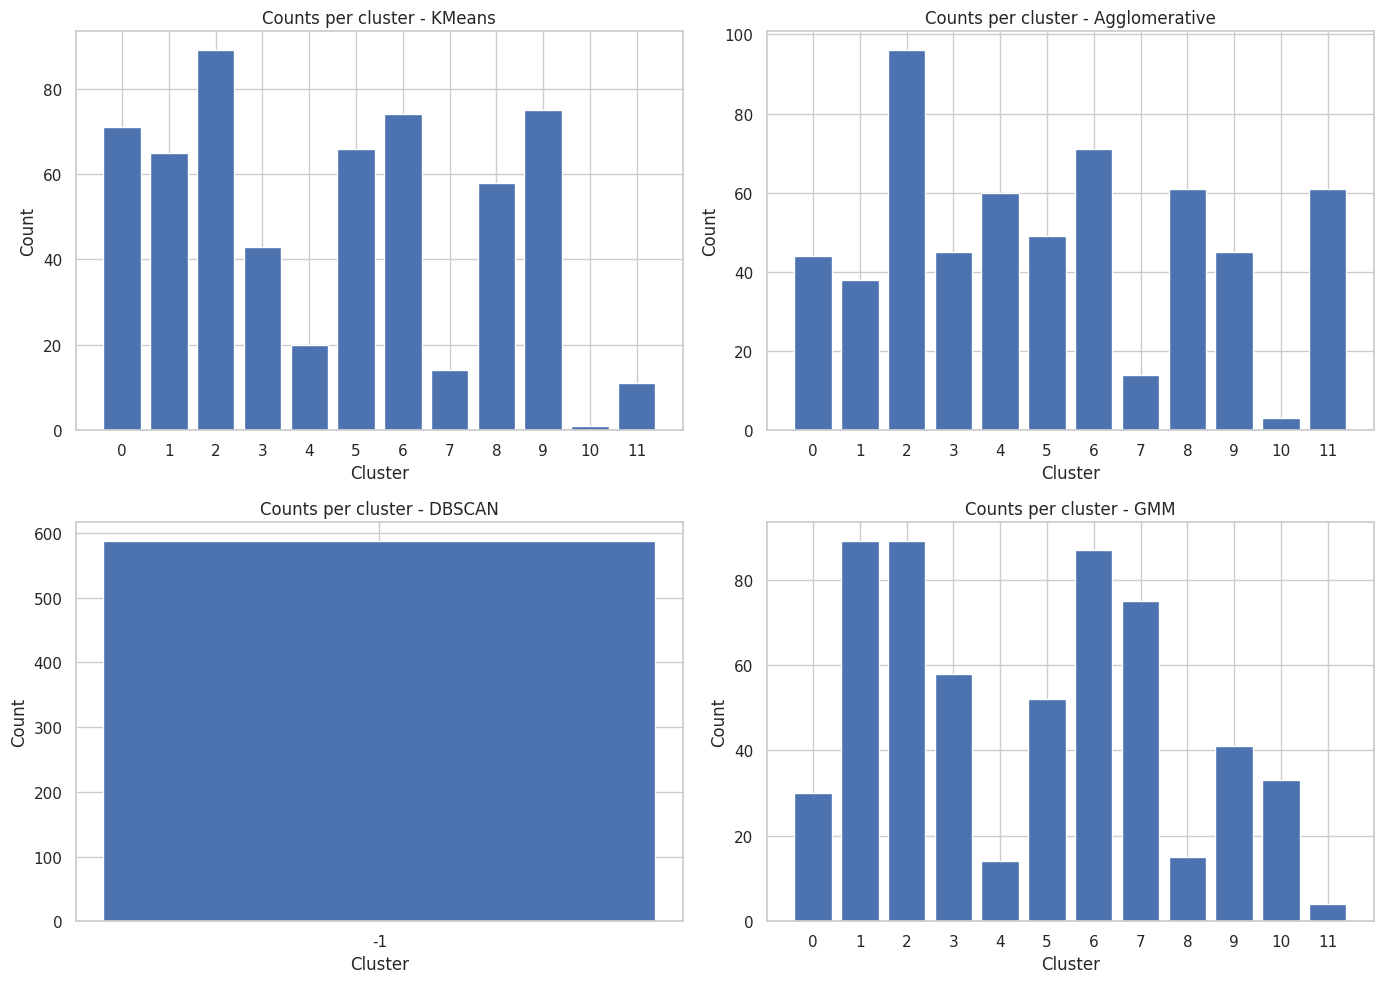

,silhouette,calinski_harabasz,davies_bouldin
KMeans,0.078172,31.019285,2.46991
Agglomerative,0.05423,28.919661,2.901878
DBSCAN,None,None,None
GMM,0.07046,29.665878,2.787103


In [8]:
# Số lượng mẫu per cluster
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for ax, (name, labels) in zip(axes, results.items()):
    unique, counts = np.unique(labels, return_counts=True)
    ax.bar([str(u) for u in unique], counts)
    ax.set_title(f'Counts per cluster - {name}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Metrics table
metrics_df = pd.DataFrame(metrics).T
metrics_df

## 9️Trực quan hóa gán nhãn chủ đề (Topic_Label) từ PhoBERT
Hiển thị phân bố chủ đề, tổng số và độ tin cậy trung bình per topic.

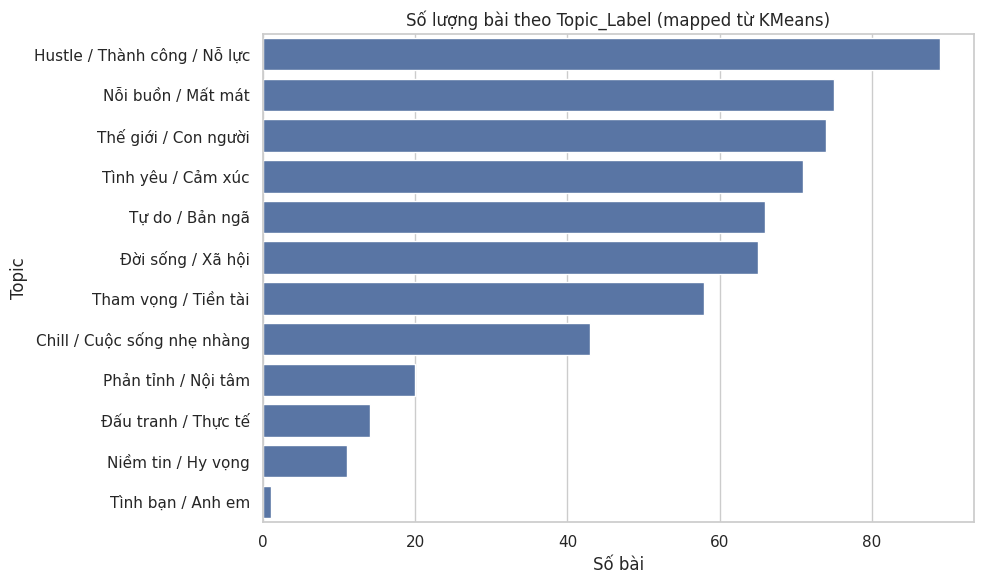

,count,mean_confidence
Topic_Label,,
Hustle / Thành công / Nỗ lực,89,0.913398
Nỗi buồn / Mất mát,75,0.899268
Thế giới / Con người,74,0.902172
Tình yêu / Cảm xúc,71,0.897271
Tự do / Bản ngã,66,0.923504
Đời sống / Xã hội,65,0.902600
Tham vọng / Tiền tài,58,0.901326
Chill / Cuộc sống nhẹ nhàng,43,0.897669
Phản tỉnh / Nội tâm,20,0.899752


In [9]:
# Nếu chưa có Topic_Label và Confidence_Score, tạo tạm (nếu cần)
if 'Topic_Label' not in df.columns:
    topic_labels = {
        0: 'Tình yêu / Cảm xúc',
        1: 'Đời sống / Xã hội',
        2: 'Hustle / Thành công / Nỗ lực',
        3: 'Chill / Cuộc sống nhẹ nhàng',
        4: 'Phản tỉnh / Nội tâm',
        5: 'Tự do / Bản ngã',
        6: 'Thế giới / Con người',
        7: 'Đấu tranh / Thực tế',
        8: 'Tham vọng / Tiền tài',
        9: 'Nỗi buồn / Mất mát',
        10: 'Tình bạn / Anh em',
        11: 'Niềm tin / Hy vọng'
    }
    # tạm map Cluster_KMeans -> Topic_Label if possible
    if 'Cluster_KMeans' in df.columns:
        df['Topic_Label'] = df['Cluster_KMeans'].map(topic_labels)
    else:
        df['Topic_Label'] = 'Unknown'

if 'Confidence_Score' not in df.columns:
    # Tạo confidence dựa trên KMeans centers nếu có
    try:
        centers = kmeans.cluster_centers_
        confs = []
        for i, emb in enumerate(embeddings):
            cid = df.loc[i, 'Cluster_KMeans']
            confs.append(cosine_similarity([emb], [centers[cid]])[0][0])
        df['Confidence_Score'] = confs
    except Exception:
        df['Confidence_Score'] = np.nan

# Phân bố chủ đề
topic_counts = df['Topic_Label'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=topic_counts.values, y=topic_counts.index)
plt.title('Số lượng bài theo Topic_Label (mapped từ KMeans)')
plt.xlabel('Số bài')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

# Bảng tóm tắt: count, mean confidence
topic_summary = df.groupby('Topic_Label').agg(count=('Lyric', 'count'), mean_confidence=('Confidence_Score', 'mean'))
topic_summary = topic_summary.sort_values('count', ascending=False)
topic_summary

##  Lưu notebook và xuất kết quả
.

In [10]:
output_path = '/content/rap_clustered_phobert_models_compared.xlsx'
df.to_excel(output_path, index=False)
print('Saved results to', output_path)

Saved results to /content/rap_clustered_phobert_models_compared.xlsx
